## Developing an automated digital reader through ML for quality control of products

In [458]:
# import the necessary packages
import numpy as np
import pandas as pd
import imutils
import cv2

import sys
from PIL import Image

from matplotlib import pyplot as plt
%matplotlib inline

from pandas import ExcelWriter
from pandas import ExcelFile

import seaborn as sn 

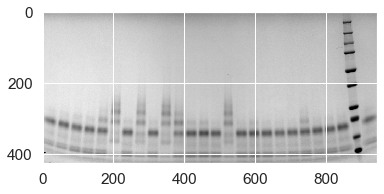

In [459]:
from gelquant import gelquant

#cropped_img =  gelquant.image_cropping("Gel7_2019-05-06_Hts103_4_8bit.png", 70, 200, 1050, 680)
#data, bounds = gelquant.lane_parser(cropped_img , 26, 1, 0, 100)

# display a sample-image
img = Image.open('cleaned_data/Gel2_2019-05-19_Hts105_6_8bit.png')
plt.imshow(np.asarray(img))
#rotated= img.rotate(-90, resample=Image.BICUBIC, expand=True)
#rotated

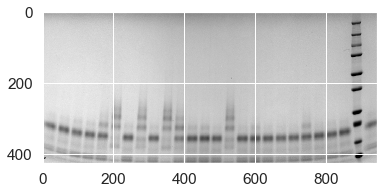

In [460]:
# Set-up to do a PIL image transformation

def find_coeffs(source_coords, target_coords):
    matrix = []
    for s, t in zip(source_coords, target_coords):
        matrix.append([t[0], t[1], 1, 0, 0, 0, -s[0]*t[0], -s[0]*t[1]])
        matrix.append([0, 0, 0, t[0], t[1], 1, -s[1]*t[0], -s[1]*t[1]])
    A = np.matrix(matrix, dtype=np.float)
    B = np.array(source_coords).reshape(8)
    res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
    return np.array(res).reshape(8)

#img = Image.open(sys.argv[1])
height, width, channels = np.shape(img)

coeffs = find_coeffs(
    [(0, 0), (width-30, 0), (width, height-15), (0, height-15)],
    [(0, 0), (width, 0), (width, height), (0, height)])

img_transform= img.transform((width, height), Image.PERSPECTIVE, coeffs, Image.BICUBIC)
plt.imshow(np.asarray(img_transform))

### A perspective transformation does help to straighten the reference lane BUT need a non-linear transformation for curves

In [461]:
np.shape(img)

(427, 945, 4)

### Now, need to strip out the individual lanes from the 26 lane gel-image

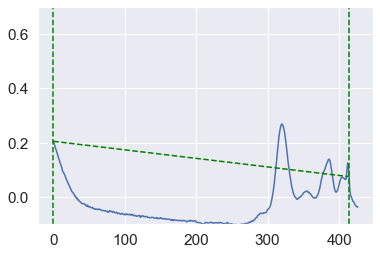

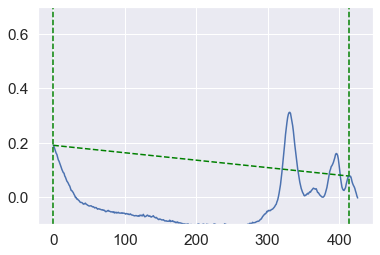

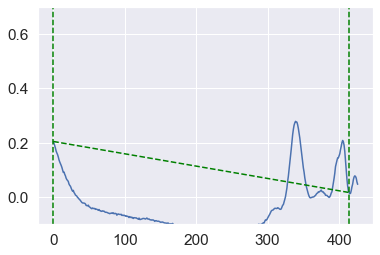

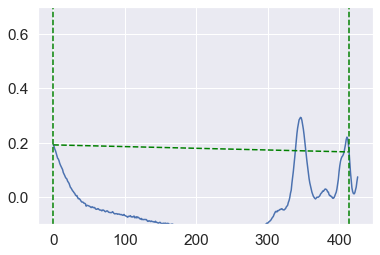

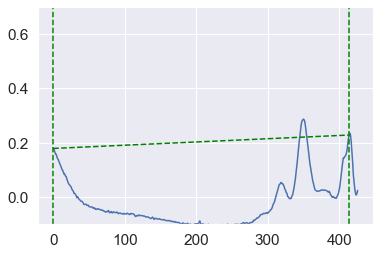

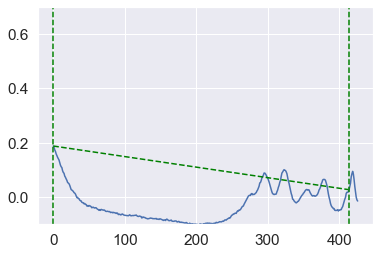

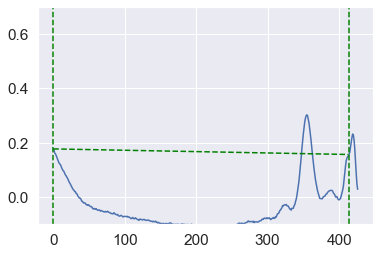

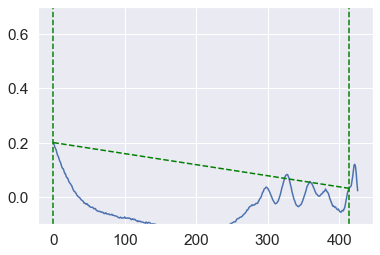

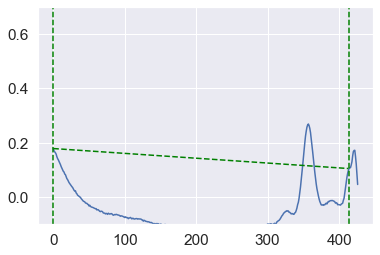

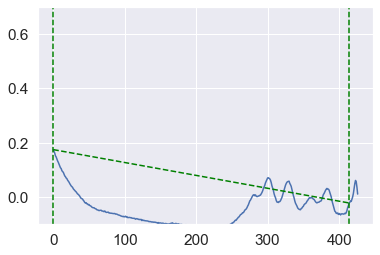

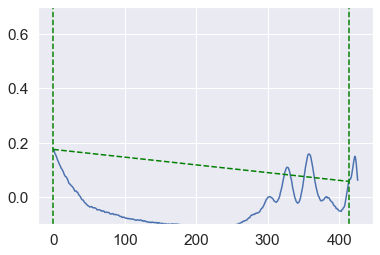

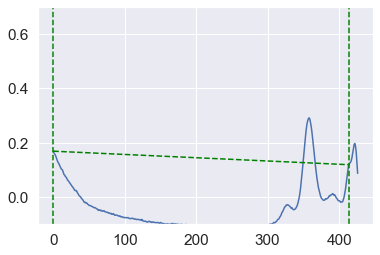

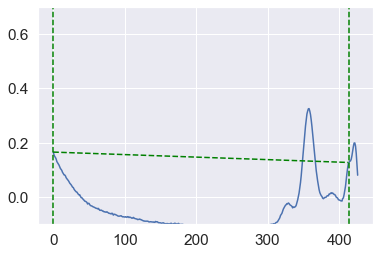

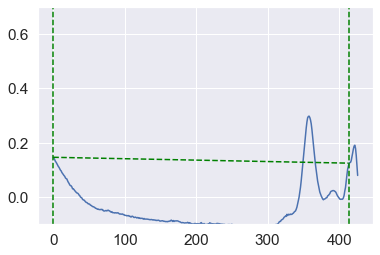

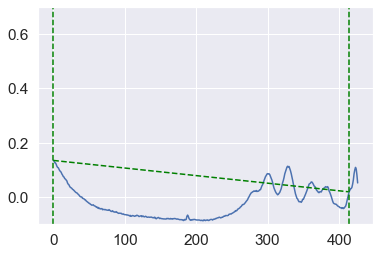

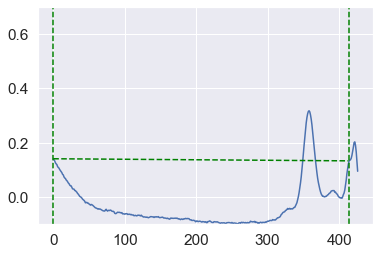

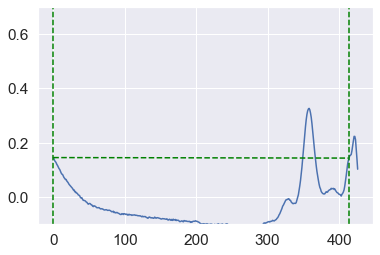

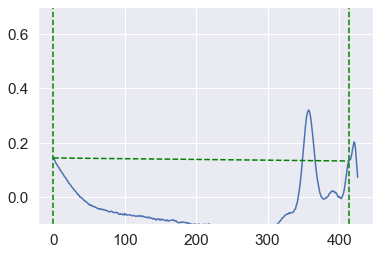

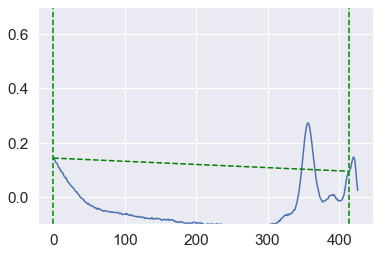

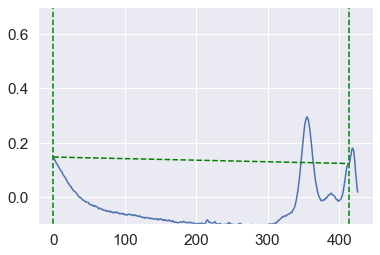

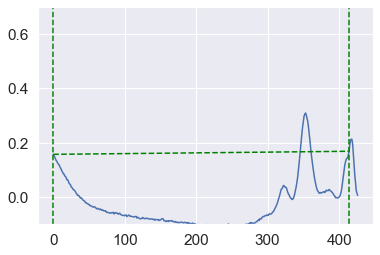

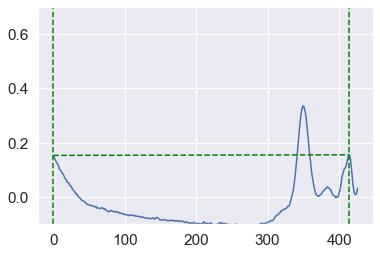

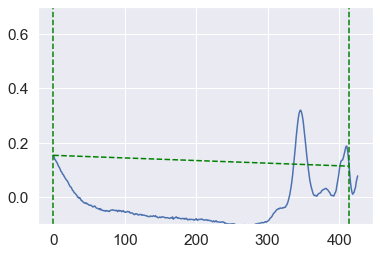

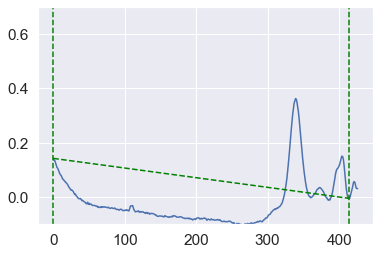

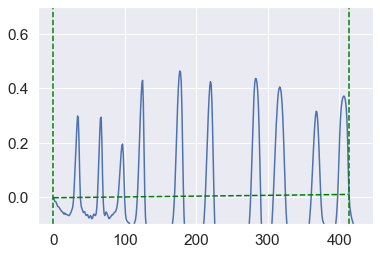

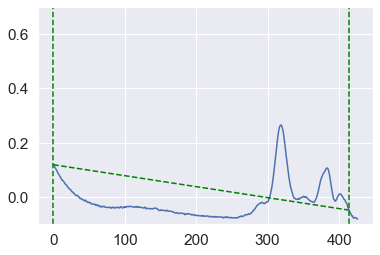

In [462]:
bounds = [250, 426]
number_lanes= 26
number_expts= 1

bounds = [250, 426]
data, bounds = gelquant.lane_parser(img_transform, number_lanes, number_expts, 0, 100)
percentages = gelquant.area_integrator(data, bounds, 1, plot_output=True)

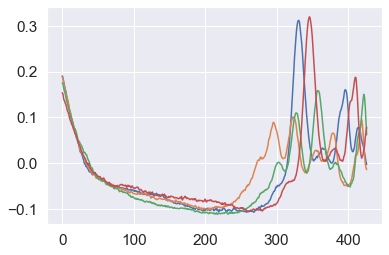

In [463]:
# some Gel-lanes samples  ....

plt.plot(data[1])
plt.plot(data[5])
plt.plot(data[10])
plt.plot(data[22])

### Read the gel-image data

In [464]:
# read gel-images ...
gels_df = pd.read_csv('processed_gels.csv', encoding='utf-8')
#gels_df.shape

# drop the EARLY part of the waveform
ys= range(0, 250)
ylist= list( map(str, ys) )
gels_df.drop(columns=ylist, inplace=True)

# drop Unnamed: 0 column
gels_df.drop(columns=['Unnamed: 0'], inplace=True)
gels_df.head(5)

,250,251,252,253,254,255,256,257,258,259,...,417,418,419,420,421,422,423,424,425,426
0,0.032848,0.037606,0.045082,0.050451,0.054598,0.059105,0.063276,0.062490,0.065526,0.066162,...,0.060452,0.055635,0.052865,0.051907,0.046262,0.045053,0.040634,0.041561,0.039707,0.039201
1,0.034327,0.036467,0.036940,0.040188,0.043943,0.050378,0.055393,0.061966,0.069056,0.075410,...,0.120774,0.116149,0.107813,0.102594,0.097922,0.092167,0.088276,0.084298,0.077226,0.071575
2,0.096600,0.100219,0.103068,0.105383,0.107766,0.114841,0.116041,0.118590,0.120688,0.125283,...,0.232004,0.203026,0.172333,0.145645,0.126590,0.117185,0.113205,0.109795,0.104291,0.097828
3,0.216396,0.220220,0.227417,0.230330,0.231471,0.237068,0.241202,0.243961,0.246322,0.248520,...,0.324284,0.332346,0.325812,0.310211,0.286310,0.253278,0.217585,0.182669,0.153233,0.134972
4,0.090055,0.091740,0.093163,0.095621,0.101688,0.104802,0.106662,0.107525,0.104694,0.106884,...,0.220632,0.235105,0.255462,0.276136,0.290372,0.291958,0.284404,0.265396,0.237731,0.201169


In [465]:
# this is a FIX to avoid dealing with renaming cols.

# temporarily make pandas dataframe a matrix
tmp= gels_df.as_matrix(columns=None)
tmp.shape

# convert matrix-back  to a data-frame
gels_df = pd.DataFrame([])
data = pd.DataFrame(tmp)
gels_df = gels_df.append(data)
gels_df.head(5)

/anaconda3/envs/gelquant/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


,0,1,2,3,4,5,6,7,8,9,...,167,168,169,170,171,172,173,174,175,176
0,0.032848,0.037606,0.045082,0.050451,0.054598,0.059105,0.063276,0.062490,0.065526,0.066162,...,0.060452,0.055635,0.052865,0.051907,0.046262,0.045053,0.040634,0.041561,0.039707,0.039201
1,0.034327,0.036467,0.036940,0.040188,0.043943,0.050378,0.055393,0.061966,0.069056,0.075410,...,0.120774,0.116149,0.107813,0.102594,0.097922,0.092167,0.088276,0.084298,0.077226,0.071575
2,0.096600,0.100219,0.103068,0.105383,0.107766,0.114841,0.116041,0.118590,0.120688,0.125283,...,0.232004,0.203026,0.172333,0.145645,0.126590,0.117185,0.113205,0.109795,0.104291,0.097828
3,0.216396,0.220220,0.227417,0.230330,0.231471,0.237068,0.241202,0.243961,0.246322,0.248520,...,0.324284,0.332346,0.325812,0.310211,0.286310,0.253278,0.217585,0.182669,0.153233,0.134972
4,0.090055,0.091740,0.093163,0.095621,0.101688,0.104802,0.106662,0.107525,0.104694,0.106884,...,0.220632,0.235105,0.255462,0.276136,0.290372,0.291958,0.284404,0.265396,0.237731,0.201169


### Data augmentation functions

In [466]:
from statsmodels import api as sm

def nextpow2(i):
    '''
    Find the next power 2 number for FFT
    '''
    
    n = 1
    while n < i: n *= 2
    return n

def shift_signal_in_frequency_domain(datin, shift):
    '''
    This is function to shift a signal in frequency domain. 
    The idea is in the frequency domain, 
    we just multiply the signal with the phase shift. 
    '''
    Nin = len(datin) 
    
    # get the next power 2 number for fft
    N = nextpow2(Nin +np.max(np.abs(shift)))
    
    # do the fft
    fdatin = np.fft.fft(datin, N)
    
    # get the phase shift for the signal, shift here is D in the above explaination
    ik = np.array([2j*np.pi*k for k in range(0, N)]) / N 
    fshift = np.exp(-ik*shift)
        
    # multiple the signal with the shift and transform it back to time domain
    datout = np.real(np.fft.ifft(fshift * fdatin))
    
    # only get the data have the same length as the input signal
    datout = datout[0:Nin]
    
    return datout

### Data Augmentation

In [467]:
# temporarily make pandas dataframe a matrix (to append lag signals)
tmp= np.empty((0, 177), float)
# tmp.shape

strt_lag= -9
end_lag= 10
inc_lag= 5

# augment shifted signals
for index, row in gels_df.iterrows():
    for lag in range(strt_lag, end_lag, inc_lag):    
        y_shift = shift_signal_in_frequency_domain(row, i)    
        tmp = np.r_[tmp, y_shift.reshape((1, 177))]

# tmp.shape
# make the data-augmented matrix to a data-frame
gels_aug_df= pd.DataFrame(tmp)
#gels_aug_df

### Read the gel-label data

In [468]:
# read labels ...
labels_df = pd.read_excel('cleaned_data/TeachingGels Score Sheet.xlsx', sheetname='Sheet1')
labels_df.drop(columns=['Unnamed: 4', 'Score Legend', 'Unnamed: 6'], inplace=True)


labels_df['CT_score'].replace('C',0,inplace=True)
labels_df['WZ_score'].replace('C',0,inplace=True)
labels_df['CT_score'].replace('M',10,inplace=True)
labels_df['WZ_score'].replace('M',10,inplace=True)


# max of. the 2 columns
labels_df['liberal_score'] = labels_df[["CT_score", "WZ_score"]].max(axis=1)

# min of. the 2 columns
labels_df['conservative_score'] = labels_df[["CT_score", "WZ_score"]].min(axis=1)


# make it a 3-class classfication problem ...
labels_df['liberal_score'].replace(-1, 0,inplace=True)
labels_df['conservative_score'].replace(-1,0,inplace=True)
labels_df['liberal_score'].replace(1, 0,inplace=True)
labels_df['conservative_score'].replace(1, 0,inplace=True)

# for ordinal case ...
labels_df['liberal_score'].replace(-2, -1,inplace=True)
labels_df['conservative_score'].replace(-2, -1,inplace=True)
labels_df['liberal_score'].replace(2, 1,inplace=True)
labels_df['conservative_score'].replace(2, 1,inplace=True)

/anaconda3/envs/gelquant/lib/python3.7/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [469]:
# augment corresponding labels into the matrix
labels_aug_df= pd.DataFrame()
for index, row in labels_df.iterrows():
    for lag in range(strt_lag, end_lag, inc_lag):    
        labels_aug_df= labels_aug_df.append(row)

#labels_aug_df

### Concatenate the gel image data with the labels

In [470]:
gels_aug_df.reset_index(drop=True, inplace=True)
labels_aug_df.reset_index(drop=True, inplace=True)

quality= pd.concat([labels_aug_df, gels_aug_df], axis=1)

# drop "M" MARKER rows
quality.drop(quality[quality.liberal_score== 10].index, inplace=True)

# drop "Unnamed: 0" BIZARRE rows
# quality.drop(columns='Unnamed: 0', inplace=True)

quality.head(10)

,CT_score,Gel,Lane,WZ_score,conservative_score,liberal_score,0,1,2,3,...,167,168,169,170,171,172,173,174,175,176
0,0.0,1.0,1.0,0.0,0.0,0.0,2.844947e-16,3.469447e-16,3.053113e-16,2.775558e-16,...,0.293471,0.283649,0.269179,0.246911,0.219308,0.193210,0.167614,0.144668,0.129173,0.120405
1,0.0,1.0,1.0,0.0,0.0,0.0,2.844947e-16,3.469447e-16,3.053113e-16,2.775558e-16,...,0.293471,0.283649,0.269179,0.246911,0.219308,0.193210,0.167614,0.144668,0.129173,0.120405
2,0.0,1.0,1.0,0.0,0.0,0.0,2.844947e-16,3.469447e-16,3.053113e-16,2.775558e-16,...,0.293471,0.283649,0.269179,0.246911,0.219308,0.193210,0.167614,0.144668,0.129173,0.120405
3,0.0,1.0,1.0,0.0,0.0,0.0,2.844947e-16,3.469447e-16,3.053113e-16,2.775558e-16,...,0.293471,0.283649,0.269179,0.246911,0.219308,0.193210,0.167614,0.144668,0.129173,0.120405
4,0.0,1.0,2.0,0.0,0.0,0.0,1.110223e-16,1.942890e-16,1.387779e-16,2.220446e-16,...,0.276811,0.279257,0.285901,0.299527,0.313737,0.328488,0.342221,0.348139,0.348843,0.340590
5,0.0,1.0,2.0,0.0,0.0,0.0,1.110223e-16,1.942890e-16,1.387779e-16,2.220446e-16,...,0.276811,0.279257,0.285901,0.299527,0.313737,0.328488,0.342221,0.348139,0.348843,0.340590
6,0.0,1.0,2.0,0.0,0.0,0.0,1.110223e-16,1.942890e-16,1.387779e-16,2.220446e-16,...,0.276811,0.279257,0.285901,0.299527,0.313737,0.328488,0.342221,0.348139,0.348843,0.340590
7,0.0,1.0,2.0,0.0,0.0,0.0,1.110223e-16,1.942890e-16,1.387779e-16,2.220446e-16,...,0.276811,0.279257,0.285901,0.299527,0.313737,0.328488,0.342221,0.348139,0.348843,0.340590
8,1.0,1.0,3.0,1.0,0.0,0.0,0.000000e+00,-2.775558e-17,-5.551115e-17,5.551115e-17,...,0.430946,0.401723,0.354375,0.306521,0.264429,0.230639,0.206674,0.194556,0.190508,0.196123
9,1.0,1.0,3.0,1.0,0.0,0.0,0.000000e+00,-2.775558e-17,-5.551115e-17,5.551115e-17,...,0.430946,0.401723,0.354375,0.306521,0.264429,0.230639,0.206674,0.194556,0.190508,0.196123


### FINALLY -- ready to build a logistic regression model

In [471]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import seaborn as sns

quality.drop(columns=['Gel', 'Lane', 'CT_score', 'WZ_score', 'conservative_score'], axis=1, inplace=True)
quality['Target'] = quality['liberal_score']

target = quality.Target.values.astype(int)

feature_cols = [i for i in list(quality.columns) if i not in ['Target', 'liberal_score', 'Unnamed: 0']]
#feature_cols

In [472]:
from sklearn.preprocessing import StandardScaler

X = quality.ix[:, feature_cols].as_matrix()

# Standarize features
scaler = StandardScaler()
features= scaler.fit_transform(X)

/anaconda3/envs/gelquant/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/envs/gelquant/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [473]:
# choose models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_absolute_error

from mord import LogisticAT

# instantiate models
model_linear = LinearRegression()
model_1vR = LogisticRegression(multi_class='ovr', class_weight='balanced')
model_multi = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced')
model_ordinal = LogisticAT(alpha=0)  # alpha parameter set to zero to perform no regularisation

# model fitting
model_linear.fit(features, target)
model_1vR.fit(features, target)
model_multi.fit(features, target)
model_ordinal.fit(features, target)

# model evaluation
target_linear_fit = model_linear.predict(features)
target_1vR_fit = model_1vR.predict(features)
target_multi_fit = model_multi.predict(features)
target_ordinal_fit = model_ordinal.predict(features)

#print('Mean absolute error:' )
print('Linear Regression: ', mean_absolute_error(target, target_linear_fit))
print('Logistic Regression (1 versus rest): ', mean_absolute_error(target, target_1vR_fit))
print('Logistic Regression (multinomial): ', mean_absolute_error(target, target_multi_fit))
print('Ordinal logistic regression: ', mean_absolute_error(target, target_ordinal_fit))


/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Linear Regression:  0.23381311197640617
Logistic Regression (1 versus rest):  0.22063037249283668
Logistic Regression (multinomial):  0.36962750716332377
Ordinal logistic regression:  0.09742120343839542


In [474]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

# divide df into features matrix and target vector
#features.drop(columns=['Gel', 'Lane', 'CT_score', 'WZ_score', 'conservative_score'], axis=1, inplace=True)
#target = features['liberal_score']

MAE = make_scorer(mean_absolute_error)
folds = 5

print('Mean absolute error:' )
MAE_linear = cross_val_score(model_linear, features, target, 
                                                  cv=folds,
                                                  scoring=MAE)
print('Linear regression: ', np.mean(MAE_linear))
MAE_1vR = cross_val_score(model_1vR, features, target, 
                                                  cv=folds,
                                                  scoring=MAE)
print('Logistic regression (one versus rest): ', np.mean(MAE_1vR))
MAE_multi = cross_val_score(model_multi, features, target, 
                                                  cv=folds,
                                                  scoring=MAE)
print('Logistic regression (multinomial): ', np.mean(MAE_multi))
MAE_ordinal = cross_val_score(model_ordinal, features, target, 
                                                  cv=folds,
                                                  scoring=MAE)
print('Ordered logistic regression: ', np.mean(MAE_ordinal))

Mean absolute error:
Linear regression:  0.6706066121780037


/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

Logistic regression (one versus rest):  0.4831449566227269


/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the nu

Logistic regression (multinomial):  0.5798871537927177
Ordered logistic regression:  0.5207680491551459


In [475]:
from sklearn.metrics import accuracy_score

def acc_fun(target_true, target_fit):
    target_fit = np.round(target_fit)
    target_fit.astype('int')
    return accuracy_score(target_true, target_fit)
    
acc = make_scorer(acc_fun)
folds = 5

print('Accuracy:' )
acc_linear = cross_val_score(model_linear, features, target, 
                                                  cv=folds,
                                                  scoring=acc)
print('Linear regression: ', np.mean(acc_linear))
acc_1vR = cross_val_score(model_1vR, features, target, 
                                                  cv=folds,
                                                  scoring=acc)
print('Logistic regression (one versus rest): ', np.mean(acc_1vR))
acc_multi = cross_val_score(model_multi, features, target, 
                                                  cv=folds,
                                                  scoring=acc)
print('Logistic regression (multinomial): ', np.mean(acc_multi))
acc_ordinal = cross_val_score(model_ordinal, features, target, 
                                                  cv=folds,
                                                  scoring=acc)
print('Ordered logistic regression: ', np.mean(acc_ordinal))

Accuracy:
Linear regression:  0.47918074756784435


/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

Logistic regression (one versus rest):  0.522559161323384


/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the nu

Logistic regression (multinomial):  0.437307126861936
Ordered logistic regression:  0.49928315412186375


In [476]:
def nuss_style_fun(ax, title):
    
    #remove top and right frame parts
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # set left and bottom axis to grey
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    
    # set ticks to grey
    ax.tick_params(axis='x', colors='grey')
    ax.tick_params(axis='y', colors='grey')
    
    #set labels to grey
    ax.yaxis.label.set_color('grey')
    ax.xaxis.label.set_color('grey') 
    
    # align axis labels with axis ends
    ax.set_xlabel(xlabel=None,
                  position=[0, 0],
                  horizontalalignment='left',
                  color='grey',
                  size=14)
    ax.set_ylabel(ylabel=None,
                  position=[0, 1],
                  horizontalalignment='right',
                  color='grey',
                  size=14)
    
    #align title
    ax.set_title(label=title,
                 loc='left',
                 color=(0.41, 0.41, 0.41),
                 size=16)
    
    return ax

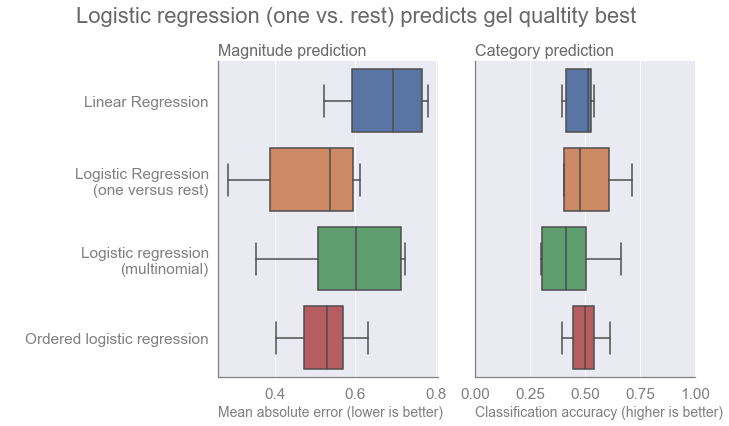

In [477]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=2, figsize=[10, 6])
fig.suptitle('Logistic regression (one vs. rest) predicts gel qualtity best\n\n',
            color='dimgrey',
             size=22)

axs[0] = nuss_style_fun(ax=axs[0], title='\n\nMagnitude prediction')

sns.boxplot(y=['Linear Regression', 'Logistic Regression\n(one versus rest)', 'Logistic regression\n(multinomial)', 'Ordered logistic regression'],
            x=[MAE_linear, MAE_1vR, MAE_multi, MAE_ordinal], ax=axs[0])
axs[0].set(xlabel='Mean absolute error (lower is better)',
      ylabel=' ')

axs[1] = nuss_style_fun(ax=axs[1], title='\n\nCategory prediction')

sns.boxplot(y=['Linear Regression', 'Logistic Regression\n(one versus rest)', 'Logistic regression\n(multinomial)', 'Ordered logistic regression'],
            x=[acc_linear, acc_1vR, acc_multi, acc_ordinal], ax=axs[1])
axs[1].set(xlabel='Classification accuracy (higher is better)',
      ylabel=' ',
      xlim=[0, 1])
axs[1].get_yaxis().set_ticks([])


fig.tight_layout()

In [478]:
features= pd.concat([labels_aug_df, gels_aug_df], axis=1)

## drop "M" rows
features.drop(features[features.liberal_score== 10].index, inplace=True)
#features.head(10)

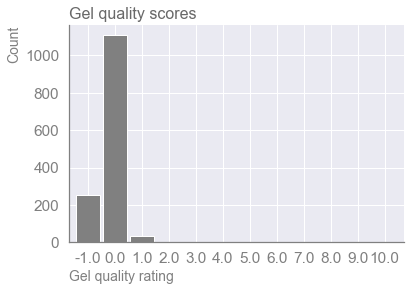

In [479]:
fig, ax = plt.subplots()
ax= nuss_style_fun(ax, title='Gel quality scores')

counts = pd.crosstab(index= features['liberal_score'],
           columns='count')
for i in range(11):
    #print(i)
    if i not in counts.index:
        #print('not', i)
        counts.loc[i, 'count']=0
counts = counts.sort_index()

counts.plot(kind='bar',
            color='grey',
            legend=False,
            width=0.9,
            ax=ax)

ax.set(xlabel='Gel quality rating',
      ylabel='Count')

ax.tick_params(axis='x', rotation=0)

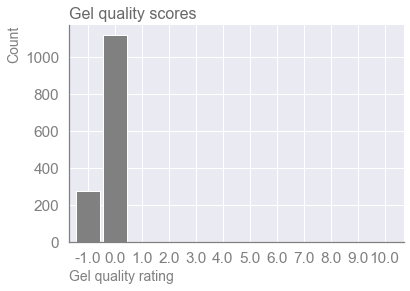

In [428]:
fig, ax = plt.subplots()
ax= nuss_style_fun(ax, title='Gel quality scores')

counts = pd.crosstab(index= features['conservative_score'],
           columns='count')
for i in range(11):
    #print(i)
    if i not in counts.index:
        #print('not', i)
        counts.loc[i, 'count']=0
counts = counts.sort_index()

counts.plot(kind='bar',
            color='grey',
            legend=False,
            width=0.9,
            ax=ax)

ax.set(xlabel='Gel quality rating',
      ylabel='Count')

ax.tick_params(axis='x', rotation=0)

In [429]:
# Repeated cv

from sklearn.model_selection import ShuffleSplit

MAE = make_scorer(mean_absolute_error)
folds = 5

MAE_linear = np.ndarray([])
MAE_1vR = pd.Series([])
MAE_multi = pd.Series([])
MAE_ordinal = pd.Series([])

cv = ShuffleSplit(n_splits=folds, test_size=1/folds)

for i in range(20):
    print('Iteration: ', i)
    MAE_linear = np.append(MAE_linear, cross_val_score(model_linear, 
                                          features, 
                                          target,
                                          cv=cv,
                                          scoring=MAE))
    MAE_1vR = np.append(MAE_1vR, cross_val_score(model_1vR, 
                                  features, 
                                  target,
                                  cv=cv,
                                  scoring=MAE))
    MAE_multi = np.append(MAE_multi, cross_val_score(model_multi, 
                                         features, 
                                         target,
                                         cv=cv,
                                         scoring=MAE))
    MAE_ordinal = np.append(MAE_ordinal, cross_val_score(model_ordinal, 
                                           features, 
                                           target,
                                           cv=cv,
                                           scoring=MAE))
print('Mean absolute error:' )
print('Linear regression: ', np.mean(MAE_linear))
print('Logistic regression (one versus rest): ', np.mean(MAE_1vR))
print('Logistic regression (multinomial): ', np.mean(MAE_multi))
print('Ordered logistic regression: ', np.mean(MAE_ordinal))

Iteration:  0


/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

Iteration:  1


/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

Iteration:  2


/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

Iteration:  3


/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

Iteration:  4


/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

Iteration:  5


/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

Iteration:  6


/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

Iteration:  7


/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

Iteration:  8


/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

Iteration:  9


/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

Iteration:  10


/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

Iteration:  11


/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

Iteration:  12


/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

Iteration:  13


/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

Iteration:  14


/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

Iteration:  15


/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

Iteration:  16


/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

Iteration:  17


/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

Iteration:  18


/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

Iteration:  19


/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/gelquant/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

Mean absolute error:
Linear regression:  5.404699764715153e-15
Logistic regression (one versus rest):  0.008714285714285714
Logistic regression (multinomial):  0.0015357142857142859
Ordered logistic regression:  0.0
